# Captstone Part 3

Before I move on to EDA, data visualisation. I have made some changes to the data cleaning part.

The first issue I realised is that, during the cleaning process, negation words are split into two parts, and the 't' after the apostrophe vanishes when I filter tokens with length more than one syllable. This makes words like "can't" end up as same as "can". This seems like not a trivial matter for sentiment analysis purpose.

The second issue I realised is that some of the URL links don't start with "http", sometimes people paste a link in "www.aaaa.com" form. This wasn't properly handled when I defined the URL address pattern as 'https?://[A-Za-z0-9./]+'.
And another problem with this regex pattern is that it only detects alphabet, number, period, slash. This means it will fail to catch the part of the URL if it contains any other special character such as "=", "_", "~", etc.</n>

The third issue is the regex pattern for Twitter ID. In the previous cleaning function I defined it as '@[A-Za-z0-9]+', but with a little googling, I found out that twitter ID also allows underscore symbol as a character can be used with ID. Except for underscore symbol, only characters allowed are alphabets and numbers.

Below is the updated datacleaning function.
The order of the cleaning is 
1. Souping
2. BOM removing
3. url address('http:'pattern), twitter ID removing
4. url address('www.'pattern) removing
5. lower-case
6. negation handling
7. removing numbers and special characters
8. tokenizing and joining

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None,encoding = "ISO-8859-1",
                 usecols=[0,5],names=['sentiment','text'])
df['sentiment'] = df['sentiment'].map({0: 0, 4: 1})
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
%%time
print ("Cleaning the tweets...\n")
clean_tweet_texts = []
for i in range(0,len(df)):
    if( (i+1)%100000 == 0 ):
        print ("Tweets {} of {} has been processed".format( i+1, len(df) )  )                                                                  
    clean_tweet_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning the tweets...

Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed


C:\Users\behdad\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b' i just received my G8 viola exam.. and its... well... .. disappointing.. :\\..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed


C:\Users\behdad\Anaconda3\lib\site-packages\bs4\__init__.py:294: UserWarning: "b'E3 ON PLAYSTATION HOME IN ABOUT AN HOUR!!!!!!!!!! \\../  \\../'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed
Wall time: 15min 59s


In [6]:
clean_df = pd.DataFrame(clean_tweet_texts,columns=['text'])
clean_df['target'] = df.sentiment
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')

In [7]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

C:\Users\behdad\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


After cleaning the tweets with the updated cleaner function, I took another look at the info()

In [8]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596041 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [9]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0


In [10]:
np.sum(my_df.isnull().any(axis=1))

3959

In [11]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

It seems like 3,981 entries have null entries for the text column. This is strange, because the original dataset had no null entries, and if there are any null entries in the cleaned dataset,
it must have happened during the cleaning process.

In [14]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",encoding = "ISO-8859-1",header=None)
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

,0,1,2,3,4,5


By looking at these entries in the original data, it seems like only text information they had was either twitter ID or it could have been URL address.
Anyway, these are the info I decided to discard for the sentiment analysis, so I will drop these null rows, and update the data frame.

In [15]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
text      1596041 non-null object
target    1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


# Word Cloud

The first text visualisation I chose is the controversial word cloud.
A word cloud represents word usage in a document by resizing individual words proportionally to its frequency and then presenting them in a random arrangement.
There were a lot of debates around word cloud, and I somewhat agree with the points of anti-wordcloud's view.
Some of the concerns over word cloud is that,
it supports only the crudest sorts of textual analysis,
and it is often applied to situations where textual analysis is not appropriate,
and it leaves viewers to figure out the context of the data by themselves without providing the narrative.

But in the case of tweets, textual analysis is the most important analysis,
and it provides a general idea of what kind of words are frequent in the corpus,
in a sort of quick and dirty way.
So, I will give it a go, and figure out what other methods can be used for text visualisation.

For the word cloud, I used the python library wordcloud.

In [16]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

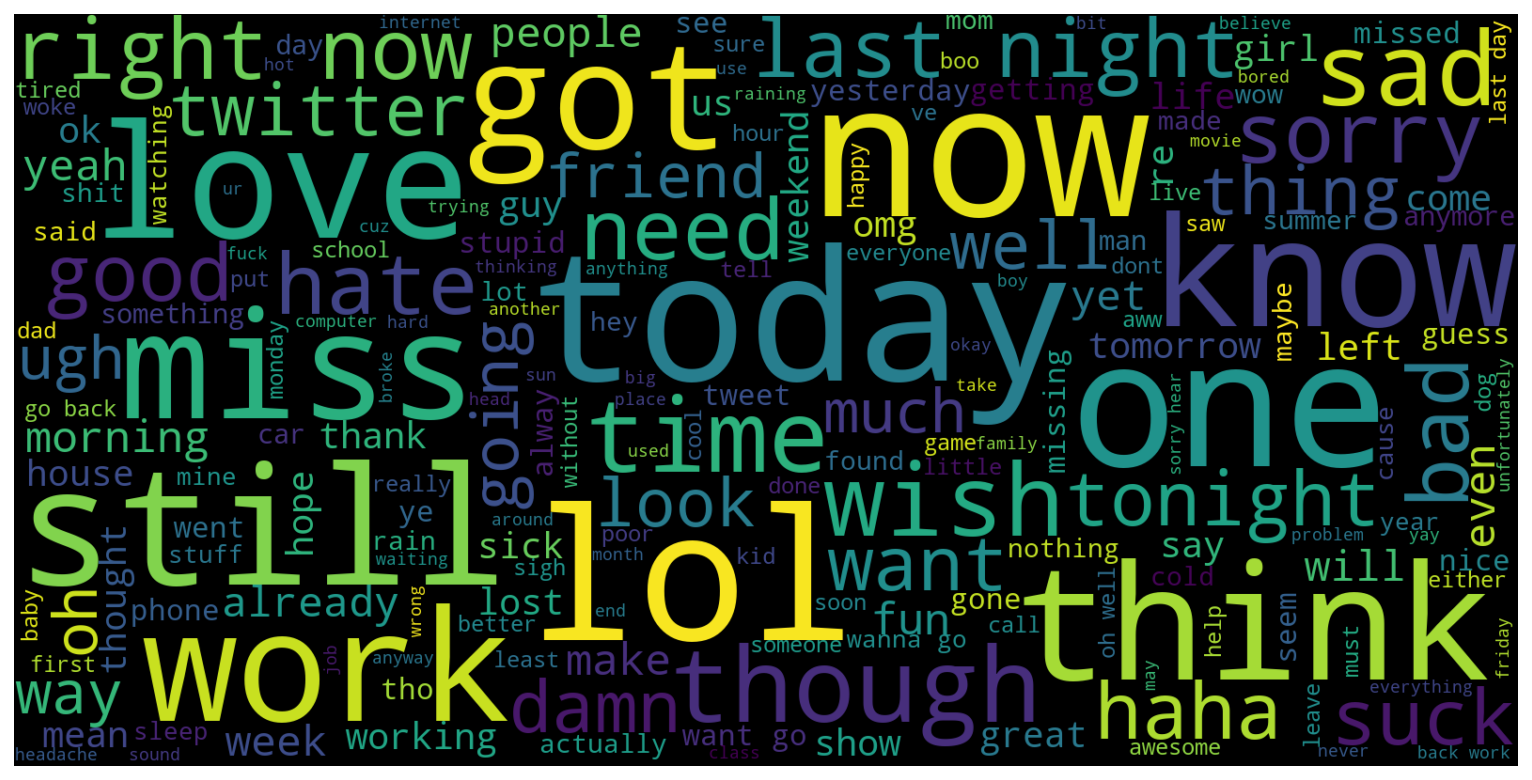

In [17]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Some of the big words can be interpreted quite neutral, such as "today","now", etc.
I can see some of the words in smaller size make sense to be in negative tweets,
such as "damn","ugh","miss","bad", etc.
But there is "love" in a rather big size, so I wanted to see what is happening.

In [19]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print (t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


OK, even though the tweets contain the word "love", in these cases it is negative sentiment because the tweet has mixed emotions like "love" but "miss". Or sometimes used in a sarcastic way.

In [20]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

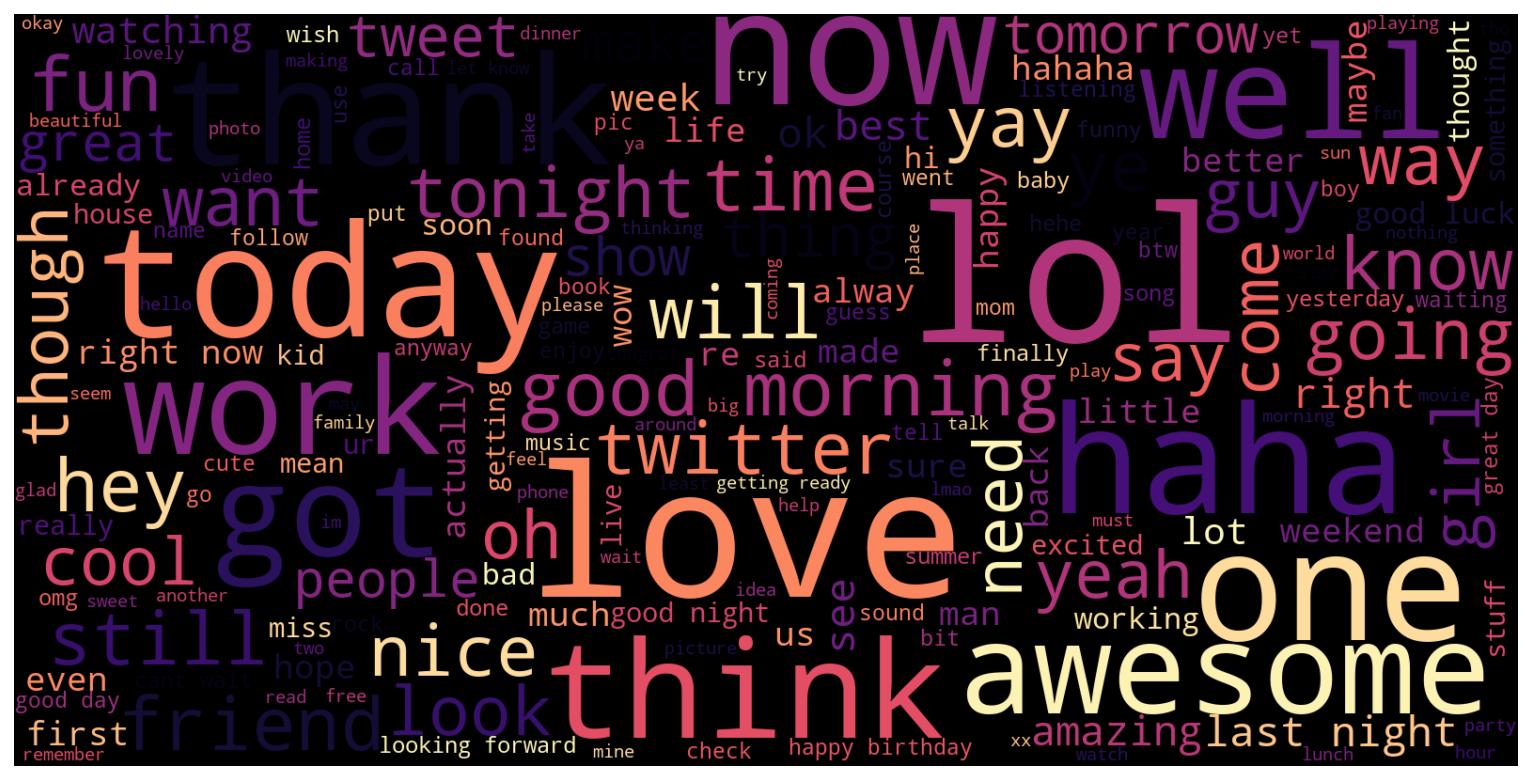

In [21]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Again I see some neutral words in big size, "today","now",
but words like "haha", "love", "awesome" also stand out.

Interestingly, the word "work" was quite big in the negative word cloud, but also quite big in the positive word cloud.
It might imply that many people express negative sentiment towards work, but also many people are positive about works.

In [22]:
del pos_tweets, pos_string, neg_tweets, neg_string, wordcloud, df

## Preparion for data visualisation

In order for me to implement a couple of data visualisation in the next step, I need term frequency data.
What kind of words are used in the tweets, and how many times it is used in entire corpus.
I used count vectorizer to calculate the term frequencies, the count vectorizer is also for fit, train and predict,
but at this stage, I will just be extracting the term frequencies for the visualisation.

There are parameter options available for count vectorizer, such as removing stop words, limiting the maximum number of terms.
However, in order to get a full picture of the dataset first, I implemented with stop words included, and not limiting the maximum number of terms.

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [24]:
len(cvec.get_feature_names())

264939

OK it looks like count vectorizer has extracted 264936 words out of the corpus.

In [25]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

Getting term frequency for each class can be obtained with the above code block, but below is what I have implemented at first when I didn't know that I didn't have to transform sparse matrix to dense one. However I will leave the below part as I have done before.

-------------------------------------------------------------------------------------------------------

For below part, I had to go through many trial and errors, because of the memory usage overload.
If the code takes time to implement, but still running, it is OK,
but it was not the matter of how long it takes the block to run,
my mac book pro just simply gave up and either killed the kernel or froze.
After numerous attempts, I have finally succeded in processing the data in batches.
The mistake I kept making was, when I slice the document matrix,
I tried to slice it in 'document_matrix.toarray()[start_index,end_index]',
and I finally realised because I was trying to first convert whole documnet_matrix to array, and then slice from there,
no matter how I change the batch size, my poor macbook pro couldn't handle the request.
After I change my slicing to 'document_matrix[start_index,end_index].toarray()',
my macbook pro did a wonderful job for me.

In [43]:
document_matrix = cvec.transform(my_df.text)

In [44]:
my_df[my_df.target == 0].tail()

,text,target
798174,sick spending my day laying in bed listening to,0
798175,gmail is down,0
798176,rest in peace farrah so sad,0
798177,sounds like rival is flagging your ads not muc...,0
798178,has to resit exams over summer wishes he worke...,0


In [45]:
%%time
neg_batches = np.linspace(0,798179,100).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(neg_batches)-2):
        print neg_batches[i+1],"entries' term freuquency calculated"
    i += 1

8062 entries' term freuquency calculated
88686 entries' term freuquency calculated
169310 entries' term freuquency calculated
249934 entries' term freuquency calculated
330558 entries' term freuquency calculated
411183 entries' term freuquency calculated
491807 entries' term freuquency calculated
572431 entries' term freuquency calculated
653055 entries' term freuquency calculated
733679 entries' term freuquency calculated
798179 entries' term freuquency calculated
CPU times: user 8min 17s, sys: 10min 54s, total: 19min 12s
Wall time: 20min 48s


In [46]:
my_df.tail()

,text,target
1596014,just woke up having no school is the best feel...,1
1596015,thewdb com very cool to hear old walt interviews,1
1596016,are you ready for your mojo makeover ask me fo...,1
1596017,happy th birthday to my boo of alll time tupac...,1
1596018,happy charitytuesday,1


In [47]:
%%time
pos_batches = np.linspace(798179,1596019,100).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    if (i % 10 == 0) | (i == len(pos_batches)-2):
        print pos_batches[i+1],"entries' term freuquency calculated"
    i += 1

806237 entries' term freuquency calculated
886827 entries' term freuquency calculated
967417 entries' term freuquency calculated
1048007 entries' term freuquency calculated
1128597 entries' term freuquency calculated
1209187 entries' term freuquency calculated
1289777 entries' term freuquency calculated
1370367 entries' term freuquency calculated
1450957 entries' term freuquency calculated
1531547 entries' term freuquency calculated
1596019 entries' term freuquency calculated
CPU times: user 8min 20s, sys: 11min 14s, total: 19min 35s
Wall time: 21min 43s


In [48]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df.head()

,0,1
aa,160,92
aaa,93,54
aaaa,45,29
aaaaa,26,12
aaaaaa,16,12


In [49]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313160,252566,565726
the,257836,265998,523834
my,190774,125955,316729
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86865,281589
is,133435,111191,244626
in,115541,101160,216701
for,98999,117369,216368


In [50]:
len(term_freq_df)

264936

In [51]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')